# Analisis de Configuraciones de paneles solares en Satelites

In [1]:
from astropy import units as u
import numpy as np
import trimesh
from Orbitas import *
import pandas as pd
from Satelitte_Solar_Power_System import Satelitte_Solar_Power_System
from tqdm import tqdm


## Introduccion
Se ha realizado un programa que permite el calculo de la potencia generada en un satelite en cualquier actitud y orbita:

 * Se cargan modelos en formato **.STP** lo que permite gran compatibilidad.
 * Tanto el calculo de la orbita como la posicion de la Tierra y el Sol estan incluidos utilizando las ephemerides del JPL.
 * Se ha creado una clase para los paneles solares, para poder caracterizar cada uno de manera independiente (by @Ignacio.GarciaSanchez).
 * Permite la utilizacion de leyes de control de Actitud.
 * Se puede ejecutar tanto en Windows y Linux (en este ultimo, las simulaciones son 50 veces mas rapidas).

Queda pendiente el desarrollo de paneles variables

## Parametros de Entrada 

    * Semieje mayor                   a = [km]
    * Excentricidad                   ecc = [1]
    * Inclinacion                     inc = [deg]
    * RAAN                            raan = [deg]
    * Argumento del perigeo           arg_ini= [deg]
    * Anomalia Verdadera              nu = [deg]
    * Fecha Inicial                   time_ini = [yyyy-mm-dd hh:mm:ss]
    * Direccion al modelo             direccion = 'models/12.STL' 

In [2]:
a = 7278 * u.km
ecc = 0 * u.one
inc = 90 * u.deg
raan = 0 * u.deg
argp_ini = 0 * u.deg
nu = 0 * u.deg
time_ini = Time("2020-01-01 12:00:00", scale="utc")
direccion = 'models/12Unuv.stl'


## Modelado del satelite 
La clase _Satelitte_Solar_Power_System_ incluye el volcado del modelo en el codigo ademas de el analisis necesario, dentro de esta funcion se puede realizar distintos cambios como el cargado de caracteristicas de panel distintas, cambios de actitud, giros, etc.


In [3]:
EPM = Satelitte_Solar_Power_System(direccion)

Tambien permite la visualizacion del modelo en unos ejes que se han tomado como VNB (Velocidad orbital <span style="color:red">**ROJO**</span>, normal a la tierra <span style="color:green">**VERDE**</span>y binormal <span style="color:blue">**AZUL**)</span>


In [4]:
ax=trimesh.creation.axis(axis_radius=25, axis_length=500)

scene = trimesh.Scene([EPM.mesh ,ax])
scene.show()

/home/javi/anaconda3/lib/python3.7/site-packages/trimesh/visual/color.py:641: RuntimeWarning: invalid value encountered in true_divide
  (-1, 1))).astype(dtype)


Como se ha comentado toda la informacion esta incluidad dentro de la clase _Satelitte_Solar_Power_System_
que en el codigo se ha creado la variable EPM

In [5]:
Base=pd.DataFrame([EPM.name, EPM.Normales_caras], index=[0,'Direccion'])
Base=Base.rename(columns=Base.iloc[0]).drop(index=0)
Base

,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
Direccion,"[0.0, 0.0, 1.0]","[0.0, 0.0, -1.0]","[-1.0, 0.0, 0.0]","[0.0, 1.0, -0.0]","[1.0, 0.0, -0.0]","[0.0, -1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"


## Simulacion 
se ha creado una funcion _propagate_fast_one_orbit_ para el analisis de una orbtia de manera los mas rapida posible y extraer los datos. A partir de aqui se introduciran las salidas y un pequeño analisis.


In [22]:
Encabezado = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                        EPM.name])
numero_iteraciones = 50

W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM,
                                                 numero_iteraciones)

Wpot = pd.DataFrame(W, columns=Encabezado)
pot = np.matrix(W).sum(axis=0) / len(W)
potOrb = pd.DataFrame(pot, index=[time_ini.iso[0:10]], columns=EPM.name)
Area_pot = pd.DataFrame(Area_potencia, columns=Encabezado)
Ang_pot = pd.DataFrame(Ang, columns=Encabezado)

W consiste en la potencia producida en cada iteracion en cada panel en [W]

In [7]:
Wpot

2020-01-01                                               \
          B+   B-        V-        N+        V+        N-   
0  19.870411  0.0  5.742584  0.710955  0.000000  0.000000   
1  19.869954  0.0  6.180577  0.000000  0.000000  0.170183   
2  19.869497  0.0  4.259638  0.000000  0.000000  1.731538   
3  19.869039  0.0  0.712478  0.000000  0.000000  3.434586   
4  19.868581  0.0  0.000000  0.000000  3.107345  2.896211   
5  19.868122  0.0  0.000000  0.000000  5.741923  0.951276   
6  19.867664  0.0  0.000000  0.238987  6.185441  0.000000   
7  19.867204  0.0  0.000000  2.765671  4.268169  0.000000   
8  19.866745  0.0  0.000000  4.207472  0.721418  0.000000   
9  19.866285  0.0  3.101410  3.592684  0.000000  0.000000   

                                                 
  B+  Panel Despegable 0 B+  Panel Despegable 1  
0              59.511881              59.511881  
1              59.510512              59.510512  
2              59.509142              57.533253  
3              59.507771              55.904762  
4              59.506399              56.019696  
5              59.505026              59.388806  
6              59.503652              59.503652  
7              57.875262              59.502277  
8              55.898308              59.500902  
9              56.013225              59.499525

La area potencia es la area de cada cara que esta recibiendo luz directa del sol en [$m^2$]

In [8]:
Area_pot

2020-01-01                                                               \
          B+    B-    V-        N+    V+        N- B+  Panel Despegable 0   
0       0.06  0.06  0.04  0.010898  0.04  0.000000               0.179700   
1       0.06  0.06  0.04  0.000000  0.04  0.005391               0.179700   
2       0.06  0.06  0.04  0.000000  0.04  0.014883               0.179700   
3       0.06  0.06  0.04  0.000000  0.04  0.021914               0.179700   
4       0.06  0.06  0.04  0.000000  0.04  0.021094               0.179700   
5       0.06  0.06  0.04  0.000000  0.04  0.014531               0.179700   
6       0.06  0.06  0.04  0.007617  0.04  0.000000               0.179700   
7       0.06  0.06  0.04  0.023789  0.04  0.000000               0.174786   
8       0.06  0.06  0.04  0.026836  0.04  0.000000               0.168820   
9       0.06  0.06  0.04  0.026133  0.04  0.000000               0.169171   

                          
  B+  Panel Despegable 1  
0               0.179700  
1               0.179700  
2               0.173733  
3               0.168820  
4               0.169171  
5               0.179349  
6               0.179700  
7               0.179700  
8               0.179700  
9               0.179700

Finalmente Ang_pot es el angulo de la normal del panel con el rayo de incidencia del sol 



In [9]:
Ang_pot

2020-01-01                                                    \
          B+        B-        V-        N+        V+        N-   
0   0.902872 -0.902872  0.391397  0.177848 -0.391397 -0.177848   
1   0.902851 -0.902851  0.421250 -0.086069 -0.421250  0.086069   
2   0.902831 -0.902831  0.290324 -0.317189 -0.290324  0.317189   
3   0.902810 -0.902810  0.048560 -0.427289 -0.048560  0.427289   
4   0.902789 -0.902789 -0.211787 -0.374324  0.211787  0.374324   
5   0.902768 -0.902768 -0.391352 -0.178474  0.391352  0.178474   
6   0.902747 -0.902747 -0.421581  0.085536  0.421581 -0.085536   
7   0.902726 -0.902726 -0.290906  0.316952  0.290906 -0.316952   
8   0.902706 -0.902706 -0.049170  0.427440  0.049170 -0.427440   
9   0.902685 -0.902685  0.211383  0.374803 -0.211383 -0.374803   

                                                 
  B+  Panel Despegable 0 B+  Panel Despegable 1  
0               0.902872               0.902872  
1               0.902851               0.902851  
2               0.902831               0.902831  
3               0.902810               0.902810  
4               0.902789               0.902789  
5               0.902768               0.902768  
6               0.902747               0.902747  
7               0.902726               0.902726  
8               0.902706               0.902706  
9               0.902685               0.902685

# Analisis

Se van a representar rapidamente los datos obtenidos en distintas fechas con actitud estativa y sin movimeintos de los paneles solares, para poder comprobar que es necesario algun cambio de actitud para tener valores decentes de potencia a lo largo del año 

## 1 de Enero

La potencia obtenida durante la orbita es de  121.526  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,16.643949,0.0,2.3038,0.725105,2.306776,1.539679,49.200248,48.806568


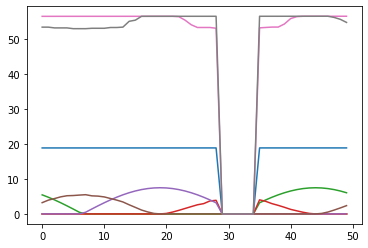

In [23]:
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Febrero

La potencia obtenida durante la orbita es de  82.247  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,10.832073,0.0,2.819797,0.485267,2.76388,2.577337,32.141079,30.627412


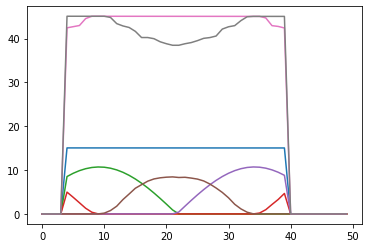

In [11]:
time_ini = Time("2020-02-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)

print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Marzo

La potencia obtenida durante la orbita es de  38.659  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,4.311306,0.0,3.284235,0.422637,3.321836,4.016957,12.686882,10.615093


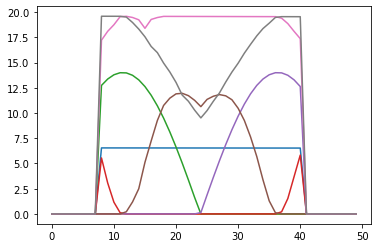

In [12]:
time_ini = Time("2020-03-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)

print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Abril 

La potencia obtenida durante la orbita es de  26.651  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,2.766469,3.314249,0.490277,3.480626,4.671132,6.793768,5.134314


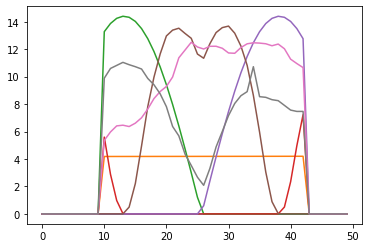

In [13]:
time_ini = Time("2020-04-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Mayo

La potencia obtenida durante la orbita es de  72.147  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,9.334911,2.889643,0.450717,3.010398,2.893378,27.675645,25.892421


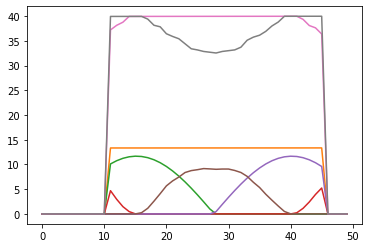

In [14]:
time_ini = Time("2020-05-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Junio

La potencia obtenida durante la orbita es de  128.121  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,17.586504,2.291243,1.012512,2.262378,1.367397,51.931437,51.669627


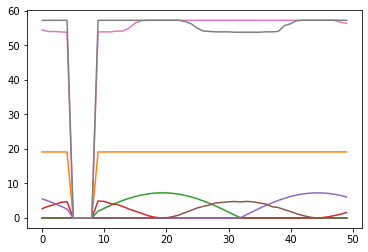

In [15]:
time_ini = Time("2020-06-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Julio

La potencia obtenida durante la orbita es de  143.29  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,19.89421,1.998183,0.848113,1.995462,1.212912,58.668431,58.673181


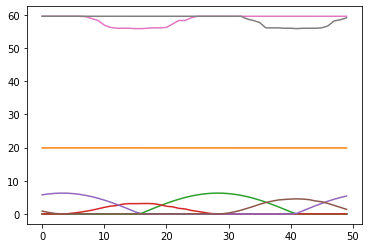

In [16]:
time_ini = Time("2020-07-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Agosto

La potencia obtenida durante la orbita es de  87.159  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,11.539174,2.83993,0.561192,2.712391,2.465911,34.207711,32.832404


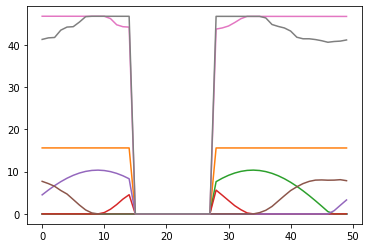

In [17]:
time_ini = Time("2020-08-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Septiembre

La potencia obtenida durante la orbita es de  41.408  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,0.0,4.720582,3.226979,0.41908,3.318586,3.959509,13.964912,11.797951


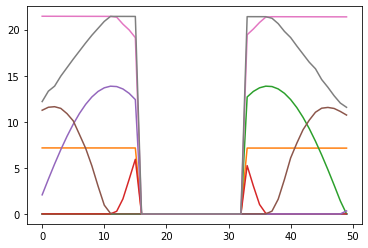

In [18]:
time_ini = Time("2020-09-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Octubre

La potencia obtenida durante la orbita es de  22.211  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,2.032891,0.0,3.548999,0.697548,3.562538,5.18589,4.003816,3.179438


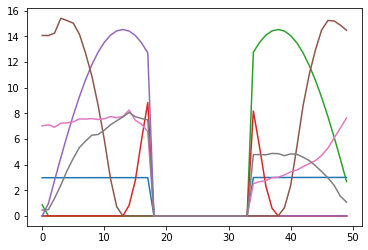

In [19]:
time_ini = Time("2020-10-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Noviembre

La potencia obtenida durante la orbita es de  71.624  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,9.202413,0.0,3.114419,0.592759,3.115328,2.889727,27.199321,25.510078


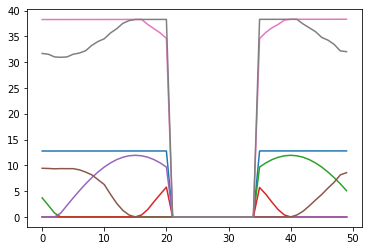

In [20]:
time_ini = Time("2020-11-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)

## 1 de Diciembre

La potencia obtenida durante la orbita es de  121.45  [W] 
 siendo la potencia por panel:


,B+,B-,V-,N+,V+,N-,B+ Panel Despegable 0,B+ Panel Despegable 1
0,16.643949,0.0,2.3038,0.901954,2.306776,1.256017,49.220163,48.817637


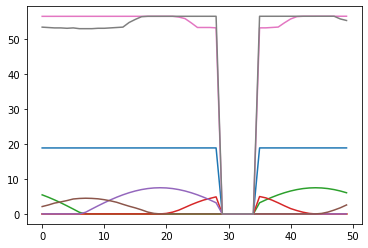

In [21]:
time_ini = Time("2020-12-01 12:00:00", scale="utc")
iter = pd.MultiIndex.from_arrays([[time_ini.iso[0:10]] * len(EPM.name),
                                  EPM.name])
W, Area_potencia, Ang = propagate_fast_one_orbit(a, ecc, inc, raan, nu,
                                                 time_ini, argp_ini, EPM, 50)

Wpot = pd.DataFrame(W, columns=iter)
pot = np.matrix(W).sum(axis=0) / len(W)
Wpot.plot(legend=False)
print('La potencia obtenida durante la orbita es de ',round(pot.sum(), 3),
      ' [W] \n siendo la potencia por panel:')
pd.DataFrame(pot, columns=EPM.name)